In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from matplotlib import image
import skimage.transform

load data

In [2]:
(train_path, test_path) = ('stage1_train/', 'stage1_test/')
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]
#define dimensions for out network's input
img_height = 128
img_width = 128
img_colors = 3
train_images = np.zeros((len(train_ids), img_height, img_width, img_colors), dtype = np.float32)
train_masks = np.zeros((len(train_ids), img_height, img_width, 1), dtype = np.bool)
test_images = np.zeros((len(test_ids), img_height, img_width, img_colors), dtype = np.float32)
#loading train data
for (i, id_) in tqdm(enumerate(train_ids), total = len(train_ids)):
    #images
    path = train_path + id_
    img = image.imread(path + '/images/' + id_ + '.png')[:, :, :img_colors]
    img = skimage.transform.resize(img, 
                                   (img_height, img_width), 
                                   preserve_range = True, 
                                   mode = 'constant')
    train_images[i] = img
    #masks
    before_mask = np.zeros((img_height, img_width, 1), dtype = np.bool)
    for mask_name in next(os.walk(path + '/masks/'))[2]:
        mask_full_path = path + '/masks/' + mask_name
        mask = image.imread(mask_full_path)
        mask = skimage.transform.resize(mask, 
                                        (img_height, img_width), 
                                        preserve_range = True,
                                        mode = 'constant')
        mask = np.expand_dims(mask, axis = -1)
        before_mask = np.maximum(before_mask, mask)
    train_masks[i] = before_mask
#loading test data
for (i, id_) in tqdm(enumerate(test_ids), total = len(test_ids)):
    #only images
    path = test_path + id_
    img = image.imread(path + '/images/' + id_ + '.png')[:, :, :img_colors]
    img = skimage.transform.resize(img, 
                                   (img_height, img_width), 
                                   preserve_range = True, 
                                   mode = 'constant')
    test_images[i] = img

100%|██████████| 65/65 [00:01<00:00, 40.98it/s]


first images


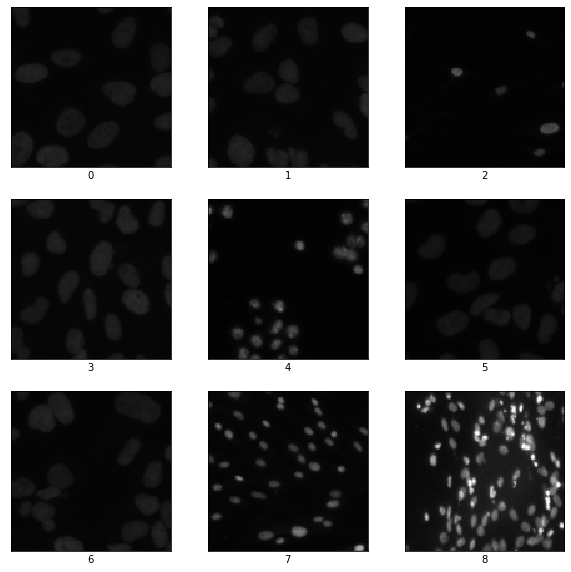

corresponding masks


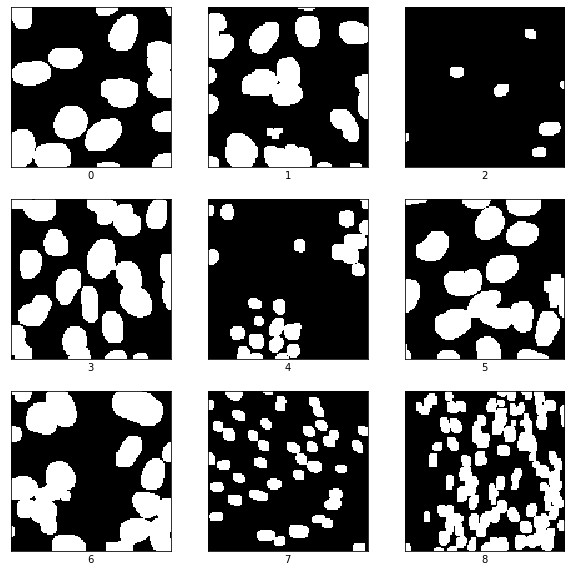

In [3]:
#images
print('first images')
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(i)
    plt.imshow(train_images[i], cmap = 'gray')
plt.show()
#masks
print('corresponding masks')
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(i)
    plt.imshow(np.squeeze(train_masks[i]), cmap = 'gray')
plt.show()

build input pipelines

In [4]:
data_gen_args = dict(vertical_flip = True, 
                     horizontal_flip = True,
                     validation_split = 0.2
                     )
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
seed = 10
train_image_generator = image_datagen.flow(train_images, seed = seed, batch_size = 64, subset = 'training')
train_mask_generator = mask_datagen.flow(train_masks, seed = seed, batch_size = 64, subset = 'training')
train_generator = zip(train_image_generator, train_mask_generator)
val_image_generator = image_datagen.flow(train_images, seed = seed, batch_size = 64, subset = 'validation')
val_mask_generator = mask_datagen.flow(train_masks, seed = seed, batch_size = 64, subset = 'validation')
val_generator = zip(val_image_generator, val_mask_generator)

build and compile model

In [5]:
#define architecture

#abstract input layer
input_layer = None
input_layer = tf.keras.layers.Input(shape = (img_height, img_width, img_colors))
#contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(input_layer)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c1)



c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c2)



c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c3)



c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c4)



c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c5)
#expansion path
u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u1 = tf.keras.layers.concatenate([u1, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(u1)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c6)



u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c6)
u2 = tf.keras.layers.concatenate([u2, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(u2)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c7)



u3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
u3 = tf.keras.layers.concatenate([u3, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(u3)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c8)



u4 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
u4 = tf.keras.layers.concatenate([u4, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(u4)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
                            kernel_initializer = 'he_normal', padding = 'same')(c9)
#output layer
output_layer = None
output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

#define and compile model
model = tf.keras.Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
#define callbacks
callbacks = list()
callbacks.append(tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss'))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir = 'logs'))
callbacks.append(tf.keras.callbacks.ModelCheckpoint('nuclei.h5', verbose = 1, save_best_only = True))
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, 
                                                      verbose = 1, cooldown = 1, min_lr = np.float32(0.000001)))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [6]:
history = model.fit(train_generator, epochs = 25, steps_per_epoch = round(len(train_images)), 
                    verbose = 1, validation_data = val_generator, 
                    validation_steps = round(len(train_images)), callbacks = callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 670 steps, validate for 670 steps
Epoch 1/25
669/670 [============================>.] - ETA: 3s - loss: 0.1353 - accuracy: 0.9448
Epoch 00001: val_loss improved from inf to 0.08446, saving model to nuclei.h5
670/670 [==============================] - 2806s 4s/step - loss: 0.1352 - accuracy: 0.9449 - val_loss: 0.0845 - val_accuracy: 0.9689
Epoch 2/25
669/670 [============================>.] - ETA: 3s - loss: 0.0736 - accuracy: 0.9702
Epoch 00002: val_loss did not improve from 0.08446
670/670 [==============================] - 2806s 4s/step - loss: 0.0736 - accuracy: 0.9702 - val_loss: 0.0908 - val_accuracy: 0.9704
Epoch 3/25
669/670 [============================>.] - ETA: 3s - loss: 0.0576 - accuracy: 0.9765
Epoch 00003: val_loss did not improve from 0.08446

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
670/670 [==============================] - 2801s 4s/step - loss: 0.0576 - accuracy: 0.9765

visually testing model on previously unseen images

first images


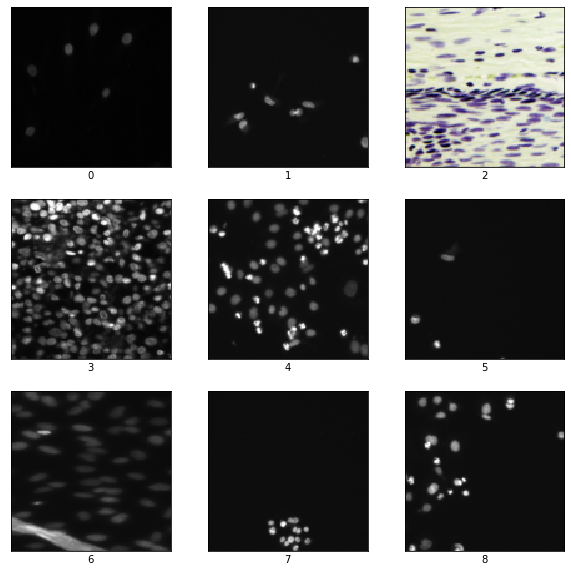

corresponding masks


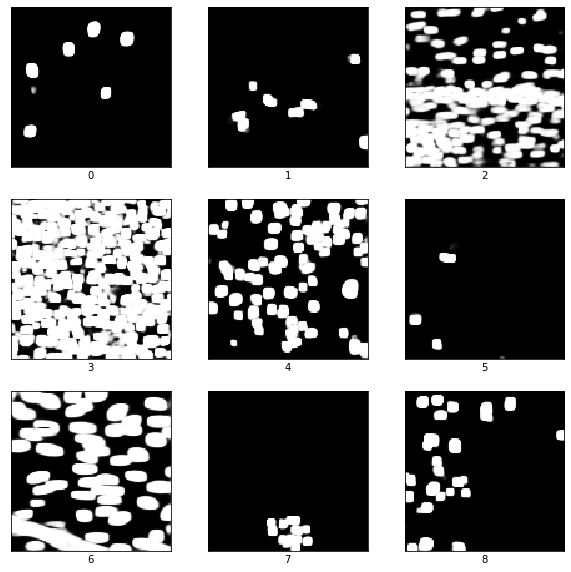

In [15]:
#images
print('first images')
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(i)
    plt.imshow(test_images[i], cmap = 'gray')
plt.show()
#masks
print('corresponding masks')
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(i)
    plt.imshow(np.squeeze(model.predict(np.expand_dims(test_images[i], axis = 0))), cmap = 'gray')
plt.show()